In [1]:
import sys
sys.path.append("../src")

from models.mamba import MambaConfig, MambaSSM, MambaModelForHourlySeries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv("../data/merged_data.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")

df["hour"] = df["datetime"].dt.hour
df["is_daytime"] = ((df["hour"] >= 7) & (df["hour"] < 19)).astype(int)

df = df.drop(columns=["hour"])

df["sin_hour"] = np.sin(2 * np.pi * df["datetime"].dt.hour / 24)
df["cos_hour"] = np.cos(2 * np.pi * df["datetime"].dt.hour / 24)
df["price_lag_1h"] = df["price_EUR_MWh"].shift(1)

df = df.dropna()

# features = [
#     "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation",
#     "quantity_biomass", "quantity_fossil_gas", "quantity_fossil_hard_coal",
#     "quantity_hydro_run_of_river", "quantity_nuclear", "quantity_solar",
#     "quantity_waste", "quantity_wind_offshore", "quantity_wind_onshore",
#     "quantity_other", "quantity_MW"
# ]
# target = "price_EUR_MWh"

features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation", "quantity_solar",
    "quantity_other", "price_lag_1h", "is_daytime", "sin_hour", "cos_hour", "quantity_MW"
]
target = "price_EUR_MWh"

# Splitting indices before scaling
val_days = 30
val_size = val_days * 24

train_df = df.iloc[:-val_size]
val_df = df.iloc[-val_size:]

# Fit scalers ONLY on training data
scaler_x = StandardScaler()
scaler_y = StandardScaler()

scaler_x.fit(train_df[features])
scaler_y.fit(train_df[[target]])

# Transform entire dataset safely
X = scaler_x.transform(df[features])
y = scaler_y.transform(df[[target]])

# scaler_x = StandardScaler()
# scaler_y = StandardScaler()

# # X = scaler_x.fit_transform(df[features])
# # y = scaler_y.fit_transform(df[[target]])


In [2]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset for time series data with fixed sequence length.
    """
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],
            self.y[idx+self.seq_len]
        )

In [3]:
class HourAheadWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model  

    def forward(self, x, **kwargs):
        seq = self.base(x)  # [B, 24]
        return seq[:, -1]

In [4]:
# Splitting the dataset into training and validation sets
# Assuming the data is hourly and we want to validate on the last 30 days
sequence_length = 24 # 24 hours = 1 day
val_days = 30
val_size = val_days * 24

train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]

val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# Model Config

config = MambaConfig(    
    state_size   = 32,
    hidden_size  = 16,
    expansion_factor = 2,
    dt_rank      = 3,
    conv_kernel_size = 3
)

# Model, optimizer, and loss function
n_epochs = 30

model = HourAheadWrapper(MambaModelForHourlySeries(config, in_features=11)).cuda()
optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.L1Loss().cuda()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)



# Training the model

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, t in train_loader:
        # print(f"Current learning rate: {scheduler.get_last_lr()}")
        x, t = x.cuda(), t.cuda()
        optimizer.zero_grad()
        preds = model(x)
        # print(f"preds shape: {preds.shape}, t shape: {t.shape}, t.squeeze(-1) shape: {t.squeeze(-1).shape}")
        loss = criterion(preds, t.squeeze(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, t in val_loader:
            x, t = x.cuda(), t.cuda()
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            val_loss += loss.item()
    model.train()

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1, Train Loss: 0.4062, Val Loss: 0.1782
Epoch 2, Train Loss: 0.2229, Val Loss: 0.1722
Epoch 3, Train Loss: 0.2196, Val Loss: 0.1704
Epoch 4, Train Loss: 0.2080, Val Loss: 0.1644
Epoch 5, Train Loss: 0.1934, Val Loss: 0.1636
Epoch 6, Train Loss: 0.1883, Val Loss: 0.1639
Epoch 7, Train Loss: 0.1818, Val Loss: 0.1602
Epoch 8, Train Loss: 0.1863, Val Loss: 0.1582
Epoch 9, Train Loss: 0.1861, Val Loss: 0.1622
Epoch 10, Train Loss: 0.2006, Val Loss: 0.1605
Epoch 11, Train Loss: 0.1852, Val Loss: 0.1564
Epoch 12, Train Loss: 0.1815, Val Loss: 0.1669
Epoch 13, Train Loss: 0.1761, Val Loss: 0.1576
Epoch 14, Train Loss: 0.1742, Val Loss: 0.1586
Epoch 15, Train Loss: 0.1823, Val Loss: 0.1605
Epoch 16, Train Loss: 0.1949, Val Loss: 0.1605
Epoch 17, Train Loss: 0.1807, Val Loss: 0.1526
Epoch 18, Train Loss: 0.1757, Val Loss: 0.1605
Epoch 19, Train Loss: 0.1690, Val Loss: 0.1558
Epoch 20, Train Loss: 0.1710, Val Loss: 0.1606
Epoch 21, Train Loss: 0.1770, Val Loss: 0.1567
Epoch 22, Train Loss: 

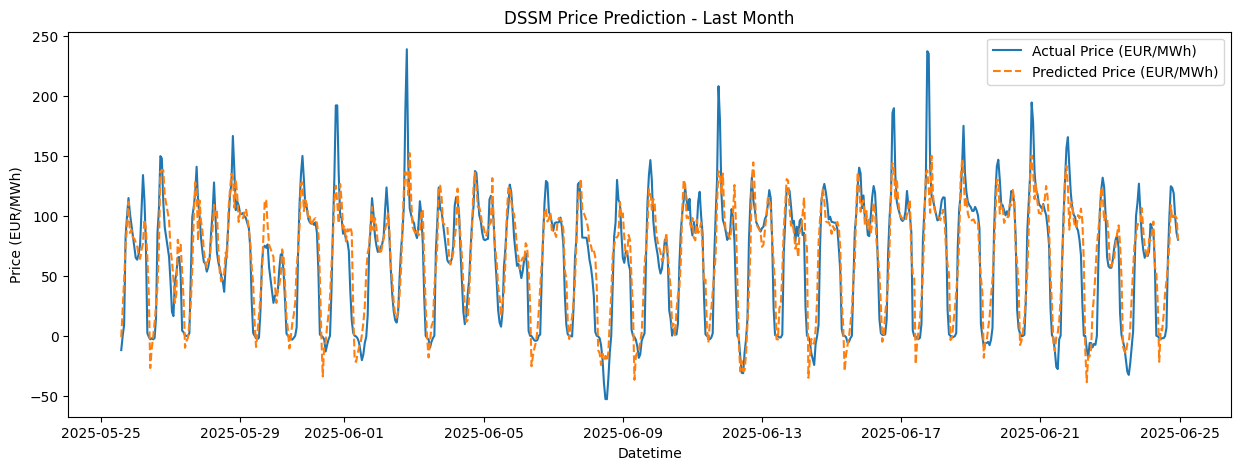

In [7]:
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for x, t in val_loader:
        x, t = x.cuda(), t.cuda()
        preds = model(x)
        all_preds.append(preds.cpu().numpy())
        all_actuals.append(t.squeeze(-1).cpu().numpy())

preds_flat = np.concatenate(all_preds)
actuals_flat = np.concatenate(all_actuals)

preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
actuals_inverse = scaler_y.inverse_transform(actuals_flat.reshape(-1, 1)).flatten()

# Plotting the results for the last month
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(val_datetimes, actuals_inverse, label="Actual Price (EUR/MWh)")
plt.plot(val_datetimes, preds_inverse, label="Predicted Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Prediction - Last Month")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

In [1]:
block_size = 6
total_blocks = 28

# Store results per block
block_metrics = []

for i in range(total_blocks):
    start = i * block_size
    end = (i + 1) * block_size

    block_actuals = actuals_inverse[start:end]
    block_preds = preds_inverse[start:end]

    mse = mean_squared_error(block_actuals, block_preds)
    mae = mean_absolute_error(block_actuals, block_preds)

    denom = (np.abs(block_actuals) + np.abs(block_preds)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(block_actuals - block_preds)[non_zero_mask] / denom[non_zero_mask]) * 100

    block_metrics.append({
        "Block": i + 1,
        "Start Hour": start,
        "End Hour": end,
        "MSE": mse,
        "MAE": mae,
        "SMAPE": smape
    })

block_df = pd.DataFrame(block_metrics)

print("\nPer Block Metrics:")
print(block_df.round(2))

# Group into Horizon Tiers
tiers = {
    "Short-term (0-24h)": block_df.iloc[0:4],
    "Medium-term (24-72h)": block_df.iloc[4:12],
    "Long-term (72-168h)": block_df.iloc[12:28]
}

print("\nAggregated Metrics by Horizon Tier:")
for tier_name, tier_df in tiers.items():
    mse_mean = tier_df["MSE"].mean()
    mae_mean = tier_df["MAE"].mean()
    smape_mean = tier_df["SMAPE"].median()
    print(f"\n{tier_name}")
    print(f"MSE: {mse_mean:.2f}")
    print(f"MAE: {mae_mean:.2f}")
    print(f"SMAPE: {smape_mean:.2f}%")
    

NameError: name 'actuals_inverse' is not defined

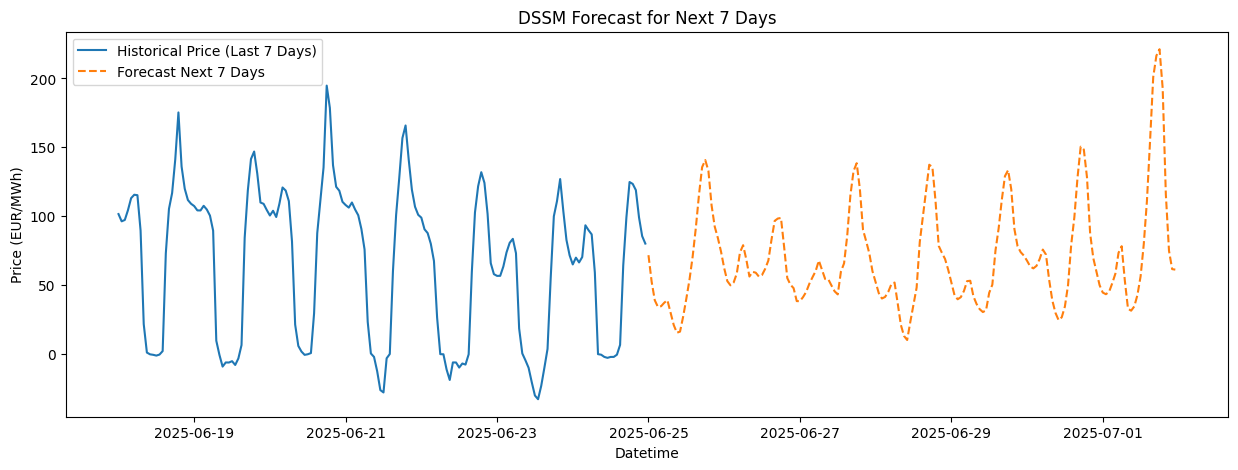

In [9]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

forecast_horizon = 168  # 7 days
sequence_length = 168

# Load weather forecast
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

# Optional: Scale weather columns now if your model expects scaled weather inputs
weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])  # Fit only on weather columns
# Scale weather forecast
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# Prepare latest known features
latest_features = df[features].iloc[-sequence_length:].copy()
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0).cuda()
current_seq = input_seq.clone()

forecast_scaled = []
forecast_unscaled = []

for i in range(forecast_horizon):
    model.eval()
    with torch.no_grad():
        pred_scaled = model(current_seq).item()  # Model predicts scaled price
        forecast_scaled.append(pred_scaled)

    pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
    forecast_unscaled.append(pred_unscaled)

    shifted_seq = current_seq[:, 1:, :].squeeze(0).cpu().numpy()
    next_feature = shifted_seq[-1].copy()

    # Update lag price feature with scaled prediction (model output already scaled)
    idx_lag = features.index('price_lag_1h')
    next_feature[idx_lag] = pred_scaled

    # Generate new datetime
    new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)

    # Update time features
    idx_day = features.index('is_daytime')
    next_feature[idx_day] = 1 if 6 <= new_datetime.hour < 20 else 0

    idx_sin = features.index('sin_hour')
    idx_cos = features.index('cos_hour')
    next_feature[idx_sin] = np.sin(2 * np.pi * new_datetime.hour / 24)
    next_feature[idx_cos] = np.cos(2 * np.pi * new_datetime.hour / 24)

    # Inject weather forecast if available
    weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
    if not weather_row.empty:
        for w_feat in weather_features:
            if w_feat in features:
                idx_w = features.index(w_feat)
                next_feature[idx_w] = weather_row.iloc[0][w_feat]
    else:
        print(f"No weather forecast for {new_datetime}, keeping last known values.")

    # Build new input sequence
    new_seq = np.vstack([shifted_seq, next_feature])
    current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0).cuda()

# Create forecast datetimes
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="h"
)

# Plot historical + forecast
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_unscaled, label="Forecast Next 7 Days", linestyle="--")
plt.title("DSSM Forecast for Next 7 Days")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()


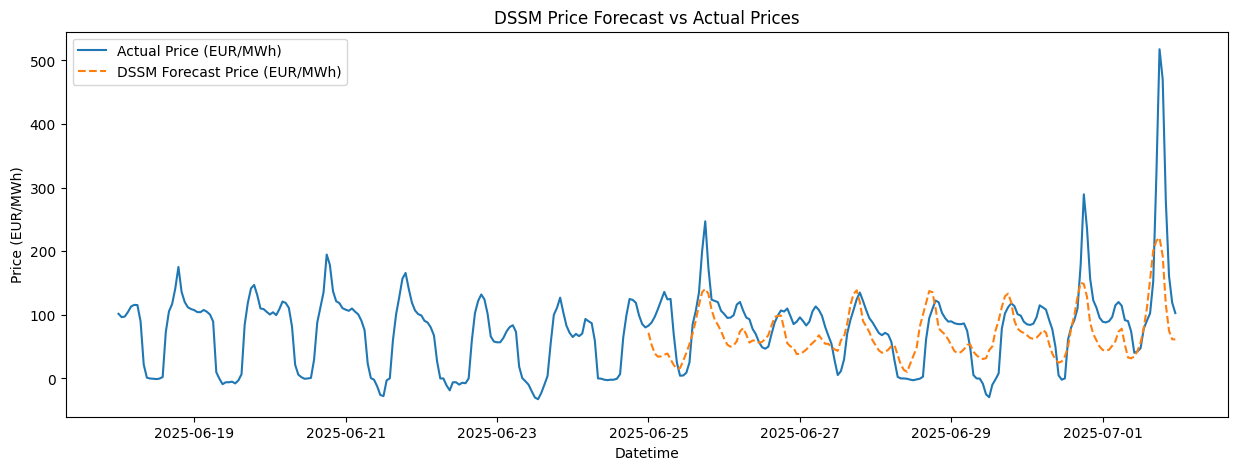

In [10]:
import sys
import pandas as pd
sys.path.append("../src")

from data.fetch_prices import get_energy_prices

df_prices = get_energy_prices("202506180000", "202507020000")

# plot vs predictions
plt.figure(figsize=(15, 5))
plt.plot(df_prices["datetime"], df_prices["price_EUR_MWh"], label="Actual Price (EUR/MWh)")
plt.plot(forecast_datetimes, forecast_unscaled, label="DSSM Forecast Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Forecast vs Actual Prices")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

